# Duplicator Info (DI) data decoder (FM encoding)
This notebook illustrates how to check that a raw stream decoder has been correctly implemented.

You might want to replace the embedded raw data block with one you decoded from a different title and test the process.

## FM sector structure

Pre-index gap (It starts right after the first edge of the index hole signal):
 - 40 bytes filled with 0xff or 0x00
 - 6 bytes filled with 0x00

Index mark:
 - 1 byte index mark 0xfc = %11111100 (written with a clock sequence that, grouped on its own, results in a byte value of 0xd7 = %11010111)

Post index gap:
 - 26 bytes filled with 0xff or 0x00
 - 6 bytes filled with 0x00

ID record (This starts the sector):
 - 1 byte ID address mark 0xfe = %11111110 (written with a clock sequence that, grouped on its own, results in a byte value of 0xc7 = %11000111)
 - 1 byte Cylinder number (0-based)
 - 1 byte Side number (0-based)
 - 1 byte Sector number (1-based)
 - 1 byte Sector length (log2(length of user data field)−7)
 - 2 bytes CRC

ID gap:
 - 11 bytes filled with 0xff or 0x00
 - 6 bytes filled with 0x00

Data record:
 - 1 byte data address mark 0xfb = %11111100 (written with a clock sequence that, grouped on its own, results in a byte value of 0xc7 = %11000111)
 - User data
 - 2 bytes CRC

Data gap:
 - 27 bytes filled with 0xff
 - 6 bytes filled with 0x00

Reference: "The floppy user guide" by Michael Haardt, Alain Knaff, David C. Niemi.

## Initialization

In [1]:
# Check versions
import sys
import matplotlib

print("Python is:", sys.version)
print("Matplotlib is:", matplotlib.__version__)

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt

Python is: 3.7.8 | packaged by conda-forge | (default, Jul 23 2020, 03:54:19) 
[GCC 7.5.0]
Matplotlib is: 3.3.3


## KryoFlux stream data
We shall be working with partial data from track 36 of "California Games", decoded from a KryoFlux raw stream. Only picking a block of the data allows us to speed up the histogram generation and bit decoding process, without loss of generality.

In [2]:
y = np.array([
0xe3,0xc9,0x86,0x60,0x73,0x9f,0x95,0x60,0x4b,0x54,0x51,0x4f,0x53,0x4f,0x4e,0x50,
0x4a,0x59,0x4f,0x4a,0x5b,0x4c,0x52,0x4e,0x4f,0x52,0x53,0x4c,0x4e,0x51,0x55,0x4e,
0x53,0x53,0x4b,0x55,0x51,0x4d,0x51,0x4f,0x4c,0x56,0x4d,0x54,0x4f,0x56,0x50,0x4a,
0x56,0x4e,0x4f,0x4d,0x58,0x4d,0x4f,0x52,0x53,0x4b,0x56,0x52,0x4a,0x56,0x4b,0x59,
0x4f,0x49,0x4e,0x57,0x4e,0x4f,0x57,0x4f,0x4e,0x51,0x52,0x50,0x51,0x4e,0x4d,0x50,
0x54,0x55,0x4e,0x53,0x4a,0x4c,0x5a,0x4d,0x50,0x50,0x52,0x4f,0x53,0x4b,0x5c,0x4c,
0x4e,0x4f,0x4c,0x54,0x4e,0x54,0x54,0x4e,0x50,0x50,0x53,0x4f,0x50,0x4d,0x54,0x4d,
0x51,0x50,0x54,0x51,0x4f,0x4f,0x4f,0x50,0x57,0x4d,0x4e,0x53,0x4a,0x58,0x4f,0x4f,
0x4e,0x56,0x50,0x4d,0x58,0x4d,0x48,0x57,0x51,0x4d,0x4f,0x51,0x4f,0x58,0x4d,0x54,
0x4d,0x51,0x4c,0x59,0x4f,0x48,0x55,0x51,0x4d,0x4f,0x58,0x4e,0x50,0x57,0x4a,0x54,
0x4b,0x4e,0x58,0x50,0x4d,0x4d,0x55,0x4f,0x51,0x52,0x4f,0x50,0x56,0x4b,0x50,0x4f,
0x51,0x54,0x50,0x4d,0x54,0x53,0x4e,0x4d,0x58,0x4c,0x49,0x58,0x4e,0x54,0x55,0x4d,
0x4d,0x50,0x4b,0x57,0x50,0x50,0x4d,0x59,0x4d,0x4d,0x53,0x4d,0x58,0x4e,0x4e,0x4e,
0x54,0x50,0x53,0x4f,0x54,0x51,0x50,0x4b,0x56,0x51,0x4b,0x4f,0x51,0x52,0x4e,0x56,
0x4e,0x55,0x4d,0x4f,0x50,0x54,0x4c,0x56,0x4d,0x52,0x4f,0x51,0x4d,0x57,0x51,0x4a,
0x4d,0x55,0x53,0x4b,0x58,0x4e,0x56,0x4a,0x51,0x50,0x4e,0x58,0x50,0x4c,0x4e,0x5b,
0x4c,0x4f,0x51,0x51,0x4d,0x55,0x4e,0x4a,0x5d,0x4d,0x52,0x4d,0x53,0x4f,0x51,0x4f,
0x53,0x53,0x4d,0x56,0x4c,0x51,0x4a,0x57,0x4c,0x54,0x50,0x50,0x4f,0x54,0x4f,0x50,
0x50,0x56,0x4f,0x4e,0x4c,0x5a,0x4a,0x4f,0x52,0x51,0x4c,0x58,0x50,0x4e,0x58,0x4b,
0x52,0x4c,0x54,0x50,0x4d,0x53,0x58,0x4a,0x4e,0x4e,0x58,0x4e,0x53,0x4d,0x4d,0x58,
0x51,0x49,0x58,0x4a,0x57,0x4a,0x53,0x56,0x4d,0x53,0x48,0x5a,0x4c,0x54,0x52,0x4c,
0x52,0x52,0x4c,0x53,0x53,0x4d,0x59,0x4a,0x50,0x4f,0x4f,0x54,0x52,0x4d,0x52,0x54,
0x4d,0x54,0x53,0x4e,0x4b,0x53,0x4e,0x51,0x56,0x4d,0x4c,0x54,0x53,0x51,0x4d,0x57,
0x4e,0x4b,0x53,0x52,0x51,0x4b,0x55,0x54,0x4a,0x54,0x4f,0x4f,0x4d,0x57,0x50,0x4f,
0x4e,0x56,0x4f,0x4f,0x54,0x4f,0x4f,0x51,0x54,0x48,0x51,0x56,0x4b,0x51,0x58,0x4e,
0x4f,0x54,0x4d,0x4e,0x52,0x55,0x4d,0x51,0x4f,0x54,0x50,0x4b,0x54,0x53,0x4a,0x52,
0x54,0x4c,0x52,0x51,0x50,0x50,0x51,0x51,0x4e,0x54,0x4c,0x50,0x52,0x4c,0x58,0x4c,
0x4f,0x54,0x50,0x4c,0x59,0x4e,0x4e,0x52,0x4c,0x4f,0x56,0x4f,0x4f,0x53,0x53,0x4b,
0x53,0x4e,0x4d,0x57,0x50,0x4e,0x51,0x4c,0x52,0x53,0x50,0x51,0x4e,0x53,0x51,0x4f,
0x4c,0x59,0x4a,0x52,0x51,0x52,0x4f,0x50,0x4a,0x57,0x4f,0x50,0x51,0x50,0x50,0x54,
0x49,0x59,0x4d,0x4d,0x4e,0x55,0x4f,0x52,0x51,0x4f,0x50,0x52,0x4f,0x51,0x50,0x51,
0x51,0x4d,0x50,0x54,0x51,0x4b,0x57,0x4b,0x4d,0x53,0x4f,0x5a,0x48,0x52,0x52,0x4b,
0x54,0x4e,0x53,0x53,0x4e,0x50,0x4f,0x50,0x54,0x4b,0x4e,0x51,0x52,0x53,0x4f,0x53,
0x4e,0x53,0x51,0x4f,0x4e,0x52,0x54,0x4b,0x51,0x50,0x51,0x4c,0x4f,0x52,0x53,0x55,
0x4e,0x48,0x58,0x4c,0x53,0x54,0x4b,0x52,0x52,0x4b,0x56,0x4e,0x52,0x52,0x48,0x54,
0x50,0x53,0x51,0x4f,0x50,0x53,0x48,0x5b,0x4a,0x50,0x55,0x4f,0x4d,0x50,0x4f,0x55,
0x50,0x4d,0x53,0x50,0x4f,0x54,0x50,0x4d,0x50,0x52,0x4f,0x51,0x4e,0x52,0x52,0x56,
0x46,0x59,0x4d,0x50,0x4d,0x55,0x4f,0x4d,0x51,0x52,0x4f,0x4e,0x50,0x58,0x4c,0x54,
0x4f,0x50,0x4a,0x54,0x52,0x4f,0x4e,0x53,0x4f,0x56,0x4b,0x50,0x54,0x4c,0x53,0x4e,
0x54,0x50,0x4f,0x51,0x50,0x51,0x51,0x54,0x4d,0x52,0x4d,0x50,0x51,0x4e,0x4f,0x55,
0x51,0x50,0x54,0x50,0x4e,0x50,0x4c,0x5d,0x95,0xa3,0xa2,0xa5,0x9c,0xa1,0xa8,0x99,
0xa6,0x9e,0xa4,0x9e,0xa0,0xa1,0xa5,0x99,0xa6,0xa2,0xa2,0xa3,0x97,0xa3,0xa2,0xa0,
0xa0,0xa2,0xa5,0x9f,0xa0,0x9e,0xa9,0x9e,0xa2,0x9f,0xa0,0x9d,0xa7,0x9f,0x9e,0x9f,
0xa3,0xa2,0x9a,0xa1,0xaa,0x9d,0xa0,0x97,0x5d,0x46,0x5d,0x9d,0x9d,0x9f,0x55,0x4d,
0x55,0x4c,0x5c,0x9b,0x9f,0x98,0x56,0x55,0x97,0xad,0x8f,0x5f,0x4b,0x4f,0x58,0x97,
0xa9,0xa0,0xa1,0xa1,0xa1,0x9f,0xa3,0x9b,0xa8,0x9a,0xa3,0xa1,0xa2,0x9b,0x55,0x55,
0x9e,0xa3,0x9e,0xa3,0xa0,0xa3,0x9a,0xa5,0x95,0x5b,0x4b,0x4d,0x60,0x9a,0xa1,0xa1,
0x9f,0xa1,0x9c,0x54,0x4f,0xa3,0x93,0x60,0x49,0x53,0x4f,0x4f,0x58,0x96,0x58,0x49,
0x58,0x4a,0x51,0x53,0x51,0x4d,0x57,0x4e,0x51,0x4e,0x56,0x4c,0x54,0x4e,0x4e,0x52,
0x4f,0x4e,0x53,0x52,0x4c,0x52,0x51,0x4e,0x56,0x4a,0x52,0x54,0x4a,0x50,0x52,0x52,
0x54,0x49,0x54,0x51,0x55,0x4f,0x4c,0x52,0x51,0x4f,0x51,0x54,0x46,0x5a,0x4c,0x53,
0x4f,0x4d,0x53,0x55,0x4e,0x50,0x4e,0x55,0x4d,0x4d,0x52,0x50,0x4f,0x54,0x4e,0x52,
0x4e,0x52,0x51,0x4b,0x54,0x53,0x4f,0x4f,0x53,0x4e,0x53,0x4e,0x4f,0x54,0x50,0x50,
0x4d,0x53,0x50,0x50,0x4e,0x54,0x52,0x52,0x48,0x56,0x52,0x4d,0x4f,0x51,0x4e,0x51,
0x52,0x51,0x54,0x4c,0x50,0x51,0x51,0x4d,0x58,0x4b,0x4f,0x52,0x4f,0x53,0x4e,0x52,
0x4e,0x52,0x55,0x4d,0x50,0x53,0x4f,0x51,0x4e,0x50,0x50,0x50,0x52,0x50,0x4e,0x57,
0x4d,0x51,0x4b,0x55,0x51,0x4b,0x53,0x52,0x4f,0x55,0x50,0x4f,0x51,0x4f,0x50,0x4f,
0x50,0x54,0x4e,0x52,0x4c,0x52,0x59,0x47,0x53,0x55,0x49,0x56,0x50,0x4f,0x51,0x4f,
0x50,0x50,0x52,0x4e,0x51,0x4d,0x59,0x48,0x54,0x52,0x4b,0x54,0x4c,0x63,0x97,0x9c,
0xa3,0xa3,0xa2,0x9d,0x9e,0xa6,0x9f,0xa2,0xa3,0x9c,0xa8,0x9a,0xa0,0xa3,0xa1,0x9b,
0xa5,0xa0,0xa3,0x99,0xa9,0x9e,0x9e,0xa1,0xa0,0x9e,0xa4,0x9f,0xa3,0xa2,0xa0,0x9e,
0xa2,0xa0,0xa3,0xa3,0x9a,0xa1,0xa8,0x98,0xa5,0xa3,0x9f,0x9f,0xa6,0x90,0x5a,0x4e,
0x5d,0x98,0xa5,0x94,0x69,0x89,0x59,0x4c,0x50,0x5c,0x98,0x9e,0xa4,0xa0,0x9c,0xa5,
0x9c,0x53,0x56,0x99,0xa6,0x9b,0xa0,0xa3,0x9c,0x52,0x5a,0x99,0xa2,0xa2,0x9d,0xa8,
0x9f,0x95,0x5a,0x50,0x4b,0x5b,0x97,0xa3,0xa7,0x9f,0x90,0x58,0x58,0x9c,0xa1,0x9e,
0xa3,0xa1,0x9d,0x9c,0x54,0x5e,0x91,0x54,0x5e,0x8b,0xa7,0x9f,0xa9,0x9b,0xa3,0x9d,
0x9f,0xa1,0xa1,0xa2,0xa1,0x9a,0x56,0x5b,0x92,0xa8,0x9e,0x9a,0xac,0x9c,0x9f,0xa3,
0xa6,0x92,0x56,0x56,0x9c,0x9f,0xa1,0xa1,0xa4,0xa0,0xa1,0xa2,0x93,0x59,0x53,0x9f,
0x9f,0xa5,0x9a,0xa1,0xaa,0x96,0xa4,0x98,0x57,0x53,0x9e,0xa1,0x9f,0xa7,0x9f,0x9e,
0xa3,0xa2,0x93,0x55,0x59,0x98,0xa7,0x9c,0xa2,0xa1,0xa4,0x9a,0xa4,0x9e,0xa5,0xa1,
0x91,0x5a,0x56,0x9b,0x9e,0xa4,0x99,0x56,0x5c,0x98,0xa3,0x98,0x56,0x57,0x97,0xa8,
0x9c,0xa1,0xa0,0xa2,0x9e,0xaf,0x8b,0x5a,0x52,0x9b,0xa5,0x9f,0xa2,0x9a,0x9d,0x5b,
0x56,0x91,0x54,0x60,0x99,0x95,0x53,0x5d,0x98,0xa4,0x9c,0xa5,0x9f,0xa3,0xa3,0x9c,
0xa2,0x9f,0x9a,0x5c,0x46,0x53,0x56,0xa3,0x95,0x54,0x5b,0x9b,0xa4,0x96,0x56,0x4b,
0x53,0x5f,0x92,0xa7,0x9d,0xa3,0x9e,0x9e,0xa1,0xa0,0xa2,0xa3,0x9d,0xa2,0xa2,0x9f,
0x99,0x56,0x58,0x9f,0x9f,0x9f,0xa3,0x9e,0xa1,0x9d,0xa2,0xa4,0x95,0x55,0x4f,0x55,
0x55,0x95,0x5b,0x53,0x99,0x4d,0x5f,0x97,0x99,0x58,0x4b,0x50,0x5d,0x92,0xa7,0xa1,
0xa2,0xa1,0x97,0x56,0x4f,0x4d,0x56,0x4a,0x5e,0x99,0x9a,0xa3,0x9f,0x9c,0x5a,0x55,
0x90,0x5b,0x4c,0x4e,0x5d,0x8b,0x5d,0x59,0x96,0x9f,0x58,0x4b,0x50,0x57,0x98,0xa4,
0xa1,0x9d,0x9f,0x97,0x5f,0x47,0x51,0x61,0x8c,0x5a,0x54,0x97,0xa5,0xa3,0x96,0x5b,
0x4d,0x48,0x60,0x9b,0x9e,0xa5,0xa0,0x93,0x57,0x55,0x9c,0x9e,0xa3,0xa2,0x94,0x5a,
0x55,0xa0,0x91,0x59,0x59,0x91,0xab,0x99,0xa9,0x9a,0x9f,0x97,0x5e,0x5a,0x91,0xa2,
0xa2,0xa2,0xa3,0x9a,0x9a,0x58,0x54,0xa2,0x9b,0x9f,0x9e,0xa2,0x9f,0x96,0x59,0x54,
0x9c,0xa3,0xa6,0x9b,0xa3,0x9a,0x98,0x5a,0x58,0x98,0xa9,0x97,0xa6,0x9d,0xa8,0x8e,
0x5b,0x5b,0x9e,0x9d,0x99,0xa3,0xa1,0xa0,0x9f,0x54,0x57,0x91,0xa7,0xa1,0x99,0xa4,
0xa7,0x93,0x56,0x52,0xa0,0xa1,0x9d,0xa3,0x9e,0x9f,0x51,0x5c,0x9a,0x9d,0xa1,0x94,
0x5c,0x52,0x4d,0x57,0x96,0x9b,0x5a,0x55,0x4c,0x54,0x8f,0x5c,0x4f,0x4f,0x5a,0x9d,
0xa3,0x94,0x58,0x49,0x58,0x59,0x8d,0x59,0x5b,0x98,0x9b,0xa2,0x99,0x5a,0x53,0x9f,
0x9e,0x9c,0xa9,0xa0,0x9a,0x52,0x54,0x95,0x5b,0x54,0x90,0x60,0x4a,0x4d,0x4d,0x51,
0x61,0x8f,0x55,0x53,0x9f,0x93,0x61,0x4c,0x4f,0x52,0x4d,0x50,0x4d,0x62,0x91,0x55,
0x52,0xa0,0x96,0x5c,0x44,0x5a,0x4e,0x50,0x58,0x95,0x9e,0x55,0x5d,0x98,0xa0,0x94,
0x58,0x5d,0x95,0xa0,0x9a,0x52,0x60,0x92,0xa1,0x98,0x5a,0x54,0x94,0x59,0x57,0x91,
0x59,0x56,0x8e,0x5a,0x59,0x9a,0x9a,0x52,0x56,0xa0,0x90,0x58,0x59,0x9d,0x95,0x59,
0x4f,0x4f,0x56,0x93,0x56,0x5c,0x90,0x55,0x58,0x9e,0xa0,0xa2,0x9e,0x95,0x5b,0x58,
0x8d,0x5b,0x57,0x8f,0x58,0x53,0x92,0x5b,0x52,0x9e,0x9e,0xa2,0x9a,0x54,0x5a,0x95,
0xa0,0xa1,0xa7,0x9e,0x94,0x57,0x58,0x9a,0x94,0x5d,0x4a,0x56,0x51,0x4e,0x56,0x94,
0x9e,0x54,0x5e,0x94,0x9a,0x59,0x4c,0x4f,0x56,0x4e,0x4d,0x4d,0x5f,0x8e,0x59,0x5a,
0x8d,0x57,0x5b,0x96,0x97,0x59,0x55,0x9a,0x98,0x5b,0x57,0x91,0x9e,0x5a,0x51,0x4c,
0x5e,0x8d,0x5a,0x55,0x91,0x5b,0x58,0x92,0x9f,0xa4,0xa4,0x98,0x52,0x56,0x92,0x60,
0x58,0x90,0x9e,0x57,0x49,0x58,0x5d,0x8d,0xa3,0xa3,0xa2,0xa2,0x9c,0xa0,0x9e,0xa2,
0xa4,0x9e,0x92,0x58,0x5d,0x96,0x9c,0xa2,0xa8,0x9b,0xa9,0x8e,0x58,0x58,0x99,0xa6,
0xa0,0xa1,0x9d,0xa3,0x96,0x4f,0x61,0x97,0xa4,0xa3,0x99,0xa6,0xa1,0x97,0x54,0x58,
0x99,0xa4,0xa5,0x9b,0x9c,0xa8,0x94,0x55,0x61,0x97,0x9b,0xa3,0x9f,0x9a,0xab,0x99,
0x54,0x58,0x9a,0xa0,0xa5,0x9f,0x98,0xaa,0x96,0x55,0x57,0x9b,0x9b,0xa2,0xa4,0x9e,
0xa7,0x95,0x52,0x5e,0x99,0xa2,0x9c,0xa3,0x9f,0xa0,0x9a,0x59,0x5a,0x98,0x9f,0x9d,
0xa4,0xa4,0x9d,0x9d,0x53,0x5a,0x9c,0xa1,0x99,0xa3,0xa0,0x9f,0x9c,0x53,0x5c,0x94,
0xa5,0xa5,0x97,0xa2,0xa7,0x96,0x57,0x5c,0x95,0xa2,0xa4,0x9d,0x9c,0xa5,0x96,0x56,
0x60,0x93,0xa1,0x9f,0xa4,0xa0,0x9f,0x9a,0x55,0x5c,0x9a,0x9c,0xa5,0x9d,0x9d,0xa5,
0x96,0x58,0x5f,0x97,0xa0,0x9c,0xa5,0xa1,0x9b,0x98,0x5d,0x5a,0x9b,0xa0,0x9b,0xa2,
0x9d,0xa0,0x9e,0x51,0x59,0x9d,0xa8,0x9e,0x98,0xa3,0xa6,0x97,0x53,0x5c,0x97,0xa1,
0x9e,0x9f,0x9e,0xa2,0xa0,0x55,0x58,0x9b,0x9a,0xa9,0x9c,0xa5,0x9b,0xa3,0x4d,0x5c,
0x95,0xa2,0x9e,0x9e,0xa2,0xad,0x90,0x58,0x58,0x9e,0x9e,0xa3,0xa0,0x9b,0xa0,0x9b,
0x55,0x58,0x9c,0x9e,0xa0,0x9f,0x9d,0xa2,0x9e,0x57,0x55,0x99,0xa7,0xa2,0x9e,0x9e,
0xa2,0x90,0x61,0x58,0x98,0xa0,0x9f,0x9c,0xa2,0xa6,0x97,0x56,0x54,0xa0,0xa3,0x9f,
0xa2,0x9c,0x9f,0x95,0x5a,0x5d,0x96,0xab,0x93,0xa0,0xa5,0xa2,0x93,0x57,0x64,0x8f,
0xa1,0xa3,0xa1,0x9c,0x9d,0xa2,0xa1,0xa4,0x9d,0xa2,0xa3,0x9f,0xa2,0xa7,0x96,0xa1,
0xa1,0x9d,0xa2,0xa0,0xa0,0xa8,0x9f,0xa3,0x9e,0xa2,0x9f,0xa4,0x9f,0x9f,0x9c,0xa1,
0xa0,0xa4,0xa0,0xa1,0x9f,0x9d,0x55,0x51,0x47,0x62,0x92,0xa0,0xa2,0x4e,0x58,0xa1,
0x92,0x58,0x55,0x4b,0x51,0x9f,0x9c,0x55,0x5a,0x9c,0xa3,0x8e,0x5c,0x50,0x4c,0x55,
0x4c,0x63,0x8d,0xa1,0xa2,0x9f,0x98,0x5a,0x57,0x9c,0x9e,0xa8,0x9b,0xa0,0xa0,0x99,
0x52,0x5c,0x8d,0x5e,0x5b,0x9b,0x9f,0x9c,0xa6,0x92,0x5b,0x4f,0x4d,0x5d,0x97,0x96,
0x5d,0x4d,0x4f,0x5b,0x99,0x97,0x5f,0x45,0x56,0x5d,0x91,0x9e,0xad,0x9c,0xa0,0x91,
0x5c,0x4a,0x51,0x5c,0x94,0xa9,0x9f,0xa1,0x99,0x5a,0x49,0x52,0x52,0x4a,0x5d,0x8c,
0x5d,0x4b,0x4e,0x59,0x4d,0x5a,0x9e,0xa0,0x9e,0x9e,0xa4,0xa0,0x9f,0x9d,0xa3,0x9e,
0xa0,0xa2,0x9a,0x4e,0x5b,0x9c,0xa3,0x99,0xa7,0x9d,0x9c,0xb0,0x9c,0x9b,0x9f,0x98,
0x5f,0x4a,0x4a,0x5c,0x4a,0x62,0x88,0x58,0x50,0x4b,0x55,0x4d,0x5f,0x92,0xa6,0x9b,
0xa2,0x9c,0xa1,0xa6,0x96,0x5a,0x5c,0x93,0x99,0x52,0x5b,0x9b,0x9d,0x52,0x5f,0x99,
0xa0,0xa0,0x98,0xa4,0x9f,0xa3,0x9d,0x4e,0x5d,0x99,0xa3,0x9b,0xa3,0xa0,0xa1,0xa0,
0x9e,0x9e,0xa0,0xa7,0x9e,0xa2,0x9a,0xa6,0xa3,0xa1,0x9f,0x9f,0x9e,0xa6,0x9f,0xa0,
0x9d,0x9d,0xa0,0xab,0x9b,0x9e,0xa1,0x9f,0xa2,0xa0,0xa6,0x99,0xa0,0x9f,0xa8,0x9c,
0x9f,0xa2,0xa8,0x98,0x9e,0x9a,0xa1,0xa9,0x9e,0xa0,0x9c,0xa0,0xa1,0xa9,0x9b,0x9e,
0xa3,0xa0,0xa2,0xa1,0x9f,0xa1,0x9d,0xa2,0xa0,0xa2,0x9e,0xa1,0x9f,0xa6,0x9b,0xa2,
0xa3,0x9e,0x9a,0xa3,0xa4,0x9f,0xa0,0xa2,0x9e,0xa7,0x9b,0x9f,0xa4,0x9c,0x9e,0xa4,
0x9f,0xa6,0x9d,0x9c,0xa2,0xa5,0xa0,0x9b,0xa5,0x9c,0xa3,0x98,0xa9,0x9e,0xa0,0xa1,
0xa4,0xa0,0x9b,0xa5,0x98,0xa1,0xa5,0x9d,0xa1,0xa3,0x9e,0xa0,0xa2,0x9f,0xa1,0xa4,
0x9c,0x9d,0xa3,0xa4,0xa1,0x9f,0xa1,0x9d,0x9c,0xa6,0x9d,0x9f,0xa5,0x9f,0xa1,0xa4,
0x99,0xa7,0x9b,0x9f,0x9e,0xa2,0xa0,0x9f,0xa9,0x99,0xa0,0xa0,0xa2,0xa7,0x99,0xa1,
0xa6,0x99,0xa6,0x9b,0x9e,0xa1,0xa1,0xa4,0x9e,0xa4,0x98,0xa7,0x9e,0xa1,0x9e,0xa3,
0x9c,0xa0,0xa5,0xa4,0x99,0xa1,0x9d,0xa9,0xa1,0x97,0xa3,0xa1,0xa8,0x99,0x9f,0xa7,
0x9f,0x9d,0x97,0x57,0x4f,0x9f,0xa2,0xa3,0xa3,0x9b,0xa9,0x92,0x52,0x5d,0x9c,0xa2,
0xa6,0x95,0xa7,0x99,0x9f,0x4c,0x5b,0x99,0xa0,0xa5,0x9c,0xa3,0xa1,0x91,0x5d,0x64,
0x8f,0xa0,0xa3,0xa3,0xa3,0x96,0x99,0x58,0x54,0x9a,0xa7,0x9a,0xa9,0x98,0xa5,0x95,
0x58,0x5e,0x96,0xa5,0xa1,0x99,0xa2,0x9c,0x9e,0x56,0x52,0x9c,0xa3,0xa6,0x9a,0xa0,
0x9e,0x96,0x5a,0x56,0xa0,0xa0,0x97,0xa3,0x9f,0xa4,0x9d,0x4f,0x59,0x99,0xa2,0x9c,
0xa6,0xa6,0x98,0x93,0x5b,0x5e,0x93,0xa1,0xa1,0x9e,0xa2,0x9c,0x9c,0x56,0x5b,0x9b,
0x9f,0xa1,0xa3,0x9c,0x9d,0x9d,0x51,0x5f,0x98,0xa3,0x9f,0x9b,0xa0,0xa2,0x95,0x5b,
0x55,0x9c,0xa4,0x9d,0xa4,0x9a,0xa0,0x99,0x59,0x54,0x9b,0xa0,0x9f,0x9e,0x9e,0xac,
0x8f,0x58,0x58,0x99,0xa3,0x9a,0xa6,0xa0,0xa0,0x99,0x56,0x5e,0x97,0x9c,0xa0,0x9f,
0x9c,0xa1,0x9d,0x54,0x5e,0x91,0xa7,0xa1,0xa1,0x9b,0x9e,0x9c,0x5b,0x53,0xa0,0x9d,
0x9b,0xa3,0xa3,0x98,0x97,0x60,0x56,0x99,0xa2,0xa2,0x9d,0xa5,0x9f,0x96,0x54,0x5c,
0x9a,0xa3,0x9e,0x99,0xa2,0xa1,0x97,0x59,0x58,0x9b,0xa3,0x9d,0x9c,0xa3,0xa2,0x95,
0x5d,0x5b,0x94,0xa0,0xa3,0x9a,0xa5,0xa2,0x91,0x60,0x54,0x9d,0xa0,0xa2,0xa0,0xa2,
0x9d,0x96,0x58,0x59,0x9a,0xa3,0x9a,0xa4,0x9d,0xa0,0x9c,0x57,0x56,0x9b,0xa2,0x9f,
0x9c,0xa4,0x9e,0x9e,0x58,0x56,0x97,0xa0,0xa4,0xa1,0x9b,0xa6,0x97,0x56,0x61,0x94,
0xa2,0x9e,0x9e,0xa8,0xa0,0x90,0x5c,0x5a,0x98,0xa0,0x9d,0xa3,0xa3,0xa0,0x8f,0x5c,
0x58,0x9b,0xa2,0xa5,0x98,0xa4,0xa1,0x9c,0x4f,0x5f,0x9e,0x9a,0x9d,0xa1,0xa4,0x9e,
0x93,0x60,0x5b,0x98,0x9d,0x9e,0xa7,0xa1,0x99,0x9b,0x57,0x58,0xa2,0x9a,0x9d,0xa2,
0xa3,0xa4,0x95,0x58,0x58,0x9e,0x9d,0x9c,0xa1,0xa0,0xa0,0x9a,0x56,0x59,0xa3,0x9b,
0xa3,0x9f,0x99,0xa1,0x99,0x5a,0x5d,0x93,0xa5,0x9c,0xa3,0x9d,0xa3,0x9c,0x57,0x5c,
0x93,0x9f,0xa6,0x9a,0xa2,0xa2,0x9b,0x50,0x58,0x9f,0x9e,0xa2,0x9e,0xa2,0x9f,0x95,
0x5c,0x59,0x9e,0x9d,0x9f,0x99,0xac,0x97,0x9e,0x59,0x59,0x94,0xa0,0xa1,0x9d,0xa9,
0xa0,0x94,0x5d,0x55,0x9a,0xa2,0xa0,0x9c,0xa0,0xa6,0x92,0x5a,0x59,0x99,0xa1,0xa1,
0x9e,0xa5,0xa5,0x93,0x52,0x5b,0x9a,0xa3,0x98,0xa7,0xa3,0xa0,0x96,0x51,0x62,0x98,
0xa2,0x9e,0x9f,0x9b,0xa7,0x9b,0x50,0x60,0x9a,0x9c,0xa5,0x9d,0x9c,0xa6,0x92,0x5d,
0x56,0x9a,0x9d,0x9e,0xa5,0xa1,0x9c,0x9b,0x5b,0x53,0xa0,0x9c,0x9b,0xac,0x9b,0x9f,
0x9b,0x59,0x5a,0x98,0x9f,0x9f,0x9e,0x9b,0xa5,0xa0,0xa7,0x9e,0x9d,0xa2,0x9e,0xa7,
0x9f,0x9f,0x9f,0xa4,0x97,0xaa,0x9a,0xa7,0x9a,0x9f,0xa4,0x9d,0xa6,0xa1,0x9f,0xa0,
0xa4,0x9c,0xa6,0xa3,0x94,0xa7,0x9c,0x97,
])

## Histogram
We generate a histogram in order to determine the thresholds corresponding to each valley.

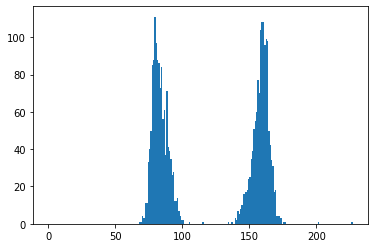

In [3]:
plt.hist(y, bins=range(0, np.amax(y) + 1, 1))
plt.show()

## Filter out short values and decode the rest
We use a simple threshold logic here, based on the above histogram.

In [4]:
bitstream = np.empty(0, int)

for v in y:
    if (v < 200 and v > 120):
        bitstream = np.append(bitstream, [1,0])
    elif (v > 50):
        bitstream = np.append(bitstream, [1])

What follows is the bitstream grouped in bytes. It clearly shows FM clocks as sequences of 0x55 (data is 0x00).

In [5]:
"".join(map(lambda b: format(b, "02x"), np.packbits(bitstream)))

'eebffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff555555555555555555555555eafd5d5f5555555755557d5575fdffffffffffffffffffffffffffffffffffffffffffff555555555555555555555555eadf5557555d555f55755577555555755555d5555d5555d5555d55555755d5d5555d55775d55555f5d5f5555555755555f775f555fd55df75f555f755f5575575d555d555d555d555d555d555d555d55755f5f7d5f755d55777f75ff75fd75757577775d75f7755777755d5575fd75ff775d75f7755775f555555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d5555555555555555555f575f5d5fd55d555dd55f5f5f555f557f7f5555557555557f7f5555d75d5557555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555d555555

## Find ID record positions
For FM, if we use the last two bytes of the post index gap and the first byte of the ID record as search pattern, what we are looking for is the below:

```
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1  = clock sequence 0xff 0xff 0xc7
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 = data sequence  0x00 0x00 0xfe
101010101010101010101010101010101111010101111110 = clock and data interleaved 0xaa 0xaa 0xaa 0xaa 0xf5 0x7e
```

We can use this pattern in order to realign the stream.

In [6]:
searchseq = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,0]
N = len(searchseq)
possibles = np.where(bitstream == searchseq[0])[0]

syncpositions = []
for p in possibles:
    check = bitstream[p:p+N]
    if np.all(check == searchseq):
        syncpositions.append(p)

print(syncpositions)

[715]


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


## Shift array to the index mark
We are now shifting bits in the bitstream so that the latter is byte-aligned and we can better recognize the pre-index gap and index mark.

In [7]:
b = np.roll(bitstream, -syncpositions[0])

In [8]:
"".join(map(lambda b: format(b, "02x"), np.packbits(b)))

'aaaaaaaaf57eaeafaaaaaaabaaaabeaabafeffffffffffffffffffffffffffffffffffffffffffffaaaaaaaaaaaaaaaaaaaaaaaaf56faaabaaaeaaafaabaaabbaaaaaabaaaaaeaaaaeaaaaeaaaaeaaaaabaaeaeaaaaeaabbaeaaaaafaeafaaaaaaabaaaaafbbafaaafeaaefbafaaafbaafaabaabaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaabaafafbeafbaaeaabbbfbaffbafebabababbbbaebafbbaabbbbaaeaabafebaffbbaebafbbaabbafaaaaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaaaaaaaaaaaaaaaaafabafaeafeaaeaaaeeaafafafaaafaabfbfaaaaaabaaaaabfbfaaaaebaeaaabaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaeaaaaaaaaaaaaaaaaaaeebffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff5555

Note: as the byte-alignment for the index mark appears to also persist through the ID gap and data record, we don't need to re-sync to the data record. Bear in mind that this is not the case in general, especially if a sector is overwritten.

## Remove clock bits and decode data

Knowing that every other bit is a clock bit we can remove clock bits, so we are left with data, i.e. ID and data records.

In [9]:
c = b[1::2]

In [10]:
"".join(map(lambda b: format(b, "02x"), np.packbits(c)))

'0000fe23000100604effffffffffffffffffffff000000000000fb01020304050004008020080200108802052003230001003530382d30343041202020202020202043363420574f4e4445524d4154204e4f524d414c0020202020202020202020202020202020202020202020202020202000000000313238202833303077000400770092010000000000000000000000000000000000000000000000202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202000000000a7fffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff8'

Let's now decode as ASCII. The string "C64 WONDERMAT NORMAL" is what stands out clearly now.

In [11]:
"".join(map(lambda b: chr(b), np.packbits(c)))

'\x00\x00þ#\x00\x01\x00`Nÿÿÿÿÿÿÿÿÿÿÿ\x00\x00\x00\x00\x00\x00û\x01\x02\x03\x04\x05\x00\x04\x00\x80 \x08\x02\x00\x10\x88\x02\x05 \x03#\x00\x01\x00508-040A        C64 WONDERMAT NORMAL\x00                           \x00\x00\x00\x00128 (300w\x00\x04\x00w\x00\x92\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00                                               \x00\x00\x00\x00§ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿø'

---